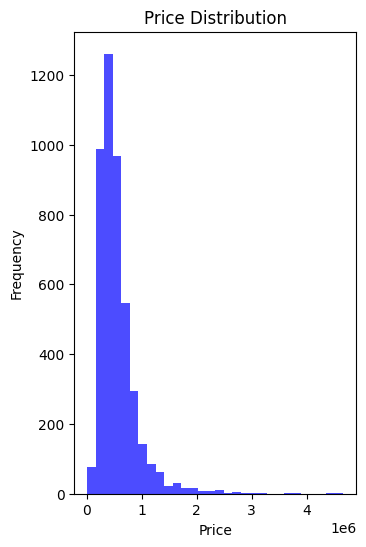

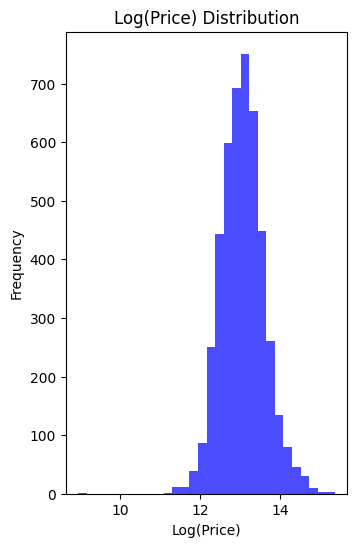

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.preprocessing import StandardScaler

# 1. Load the dataset
df = pd.read_csv("house_dataset_processed.csv")

# Plot the price distribution
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.hist(df["price"], bins=30, color='blue', alpha=0.7)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")

# Plot the log(price) distribution
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.hist(np.log(df["price"]), bins=30, color='blue', alpha=0.7)
plt.title("Log(Price) Distribution")
plt.xlabel("Log(Price)")
plt.ylabel("Frequency")
plt.show()

# 2. Extract features and target variable, and apply log transformation to the target
X = df.drop(columns=["price"])
y = np.log(df["price"])


Log transformation of price is applied to reduce skewness, stabilize variance, and improve model performance. It helps linear models better capture relative changes and handle heteroscedasticity commonly found in housing price data.

In [25]:
# 3. Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Define Models
models = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1)
}

# 5. Cross-Validation Setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# 6. Evaluate Model Performance
results = []
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=kf, scoring=mape_scorer)
    results.append({
        "Model": name,
        "MAPE Mean": -scores.mean(),
        "MAPE Std": scores.std()
    })

results_df = pd.DataFrame(results)
print("Model Performance Evaluation:")
print(results_df)




Model Performance Evaluation:
   Model  MAPE Mean  MAPE Std
0    OLS   0.018883  0.000389
1  Ridge   0.018881  0.000393
2  Lasso   0.024050  0.000383


Interpretation:

Ridge regression achieved the lowest MAPE (0.018881), but the difference from OLS (0.018883) is negligible. Both models perform equally well in terms of predictive accuracy.

Lasso regression performed significantly worse, with a MAPE of 0.024050. This suggests that excessive regularization may have removed important features.

The low standard deviation across all models (~0.00038) indicates consistent and stable performance across folds during cross-validation.

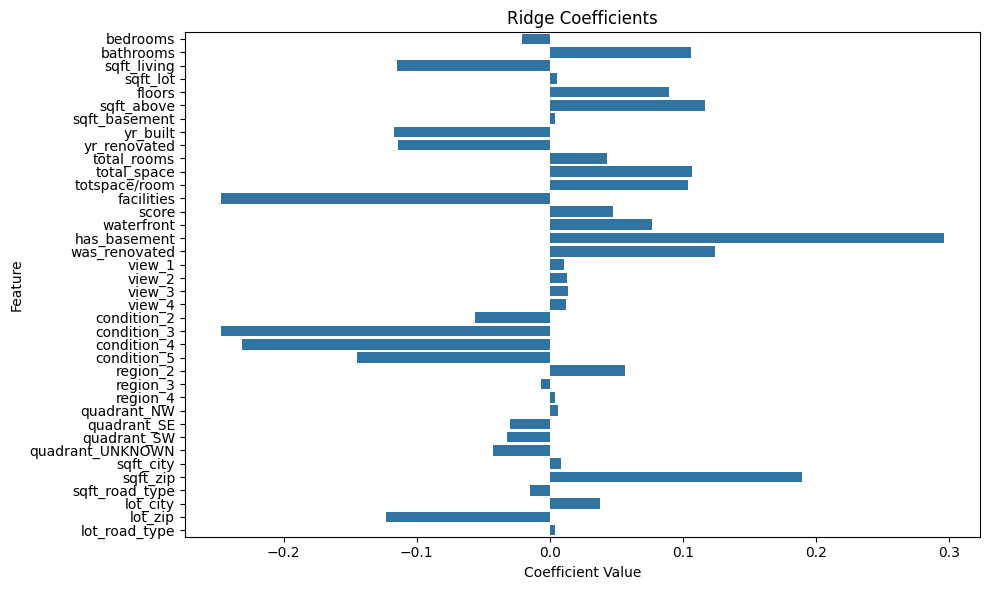

In [26]:
# 7. Fit the Best Model
best_model_name = results_df.sort_values(by="MAPE Mean").iloc[0]["Model"]
best_model = models[best_model_name]
best_model.fit(X_scaled, y)

# 8. Predictions and Residuals
y_pred = best_model.predict(X_scaled)
residuals = y - y_pred

# 9. Regression Coefficients Visualization
coefs = pd.Series(best_model.coef_, index=X.columns)

plt.figure(figsize=(10, 6))
sns.barplot(x=coefs.values, y=coefs.index)
plt.title(f"{best_model_name} Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

The Ridge regression coefficient plot reveals which features most strongly influence the predicted log-transformed house prices. The most impactful positive coefficient is associated with the presence of a basement, indicating that homes with basements are valued significantly higher. Other notable positive predictors include the average space per room and the average home size within a ZIP code, both suggesting that spaciousness and location within more upscale neighborhoods drive prices up. On the negative side, the number of facilities surprisingly shows a strong negative effect, which may reflect data-specific patterns such as higher facility density in lower-priced or older areas. Additionally, certain condition levels (like condition_3 and condition_4) have substantial negative coefficients, highlighting a price penalty for homes in only average condition. Most other features have relatively small coefficients, suggesting more modest or negligible effects on price in this regularized linear model. All features were standardized prior to modeling, so the magnitude of each coefficient is directly comparable.

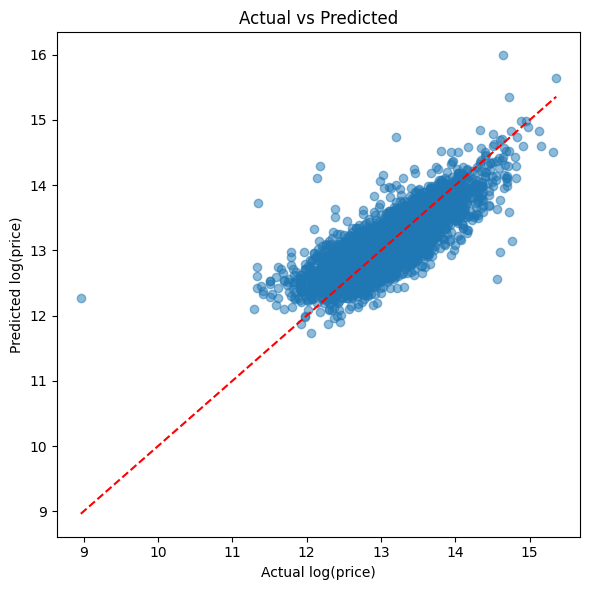

In [27]:
# 10. Actual vs Predicted Plot
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual log(price)")
plt.ylabel("Predicted log(price)")
plt.title("Actual vs Predicted")
plt.tight_layout()
plt.show()

The "Actual vs Predicted" plot demonstrates a strong alignment between the predicted log-transformed house prices and their true values. Most data points cluster tightly around the 45-degree red reference line, indicating that the Ridge regression model provides accurate and consistent predictions. The relatively small spread of points around the diagonal suggests low bias and variance, while the absence of clear curvature or heteroscedasticity implies that the linear model structure is appropriate for the log-transformed target. A few outliers are present, but they do not significantly distort the overall model performance.

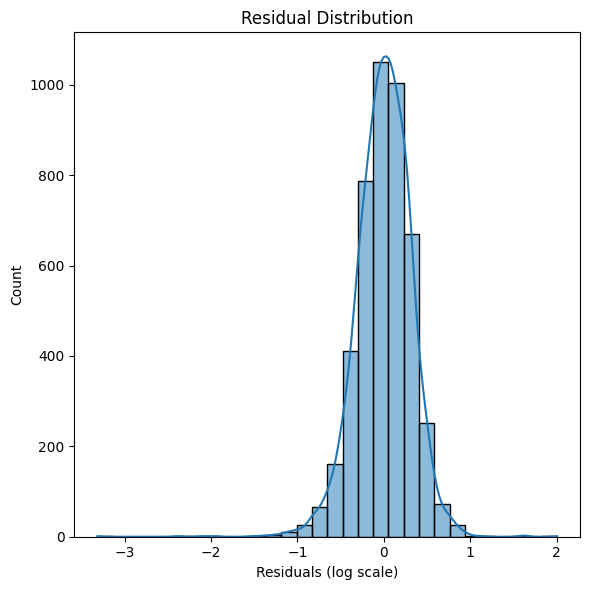

In [28]:
# 11. Residual Distribution Plot
plt.figure(figsize=(6, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residual Distribution")
plt.xlabel("Residuals (log scale)")
plt.tight_layout()
plt.show()


The residual distribution plot shows that the prediction errors from the Ridge regression model are approximately normally distributed and centered around zero. The histogram forms a bell-shaped curve with slight symmetry, and the kernel density estimate aligns closely with a Gaussian distribution. This indicates that the model’s errors are random and unbiased, satisfying one of the key assumptions of linear regression. Moreover, the relatively narrow spread of residuals suggests that the model has low error variance, further supporting its reliability in predicting log-transformed house prices.



In [29]:
# 12. Model Summary with Original Data MAPE
# Transform predictions back to the original scale
y_pred_original = np.exp(y_pred)
y_original = np.exp(y)

# Calculate MAPE for original data
mape_original = mean_absolute_percentage_error(y_original, y_pred_original)

print(f"Best Model: {best_model_name}")
print("Model Coefficients:")
for feature, coef in zip(X.columns, best_model.coef_):
    print(f"{feature}: {coef:.4f}")
print("Model Intercept:")
print(f"{best_model.intercept_:.4f}")
print("Model Performance:")
print(f"MAPE (Log-Transformed): {-results_df.sort_values(by='MAPE Mean').iloc[0]['MAPE Mean']:.4f}")
print(f"MAPE (Original Data): {mape_original:.4f}")


Best Model: Ridge
Model Coefficients:
bedrooms: -0.0212
bathrooms: 0.1061
sqft_living: -0.1150
sqft_lot: 0.0055
floors: 0.0897
sqft_above: 0.1167
sqft_basement: 0.0039
yr_built: -0.1174
yr_renovated: -0.1141
total_rooms: 0.0426
total_space: 0.1064
totspace/room: 0.1034
facilities: -0.2469
score: 0.0474
waterfront: 0.0766
has_basement: 0.2959
was_renovated: 0.1241
view_1: 0.0108
view_2: 0.0132
view_3: 0.0133
view_4: 0.0124
condition_2: -0.0560
condition_3: -0.2468
condition_4: -0.2312
condition_5: -0.1450
region_2: 0.0563
region_3: -0.0064
region_4: 0.0036
quadrant_NW: 0.0063
quadrant_SE: -0.0300
quadrant_SW: -0.0324
quadrant_UNKNOWN: -0.0424
sqft_city: 0.0082
sqft_zip: 0.1890
sqft_road_type: -0.0151
lot_city: 0.0378
lot_zip: -0.1234
lot_road_type: 0.0038
Model Intercept:
13.0626
Model Performance:
MAPE (Log-Transformed): -0.0189
MAPE (Original Data): 0.2630
